In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor,RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import seaborn as sns
from pyod.models.mad import MAD
import statsmodels.api as sm
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RandomizedSearchCV

In [114]:
#Load the data
X_train_unfiltered =np.load('X_train.npy')
Y_train_unfiltered =np.load('y_train.npy')
X_test =np.load('X_test.npy')

In [115]:
# Create a dataframe for the training data and standardize the features
train_features = ['Air Temperature','Water Temperature','Wind speed','Wind Direction','Illumination']
#Define the colours for the plots associated with each feature
colours = ['deepskyblue', 'aqua', 'mediumvioletred', 'teal', "gold"]
X_train_unfiltered = pd.DataFrame(X_train_unfiltered)
X_train_unfiltered = X_train_unfiltered.rename(columns={i:train_features[i] for i in range(5)})
y_train_df = pd.DataFrame(Y_train_unfiltered)
y_train_df.rename(columns={0:'y_train'}, inplace=True)
train_data_unfiltered = X_train_unfiltered.copy()
train_data_unfiltered['Y_train'] = y_train_df.reset_index(drop=True)

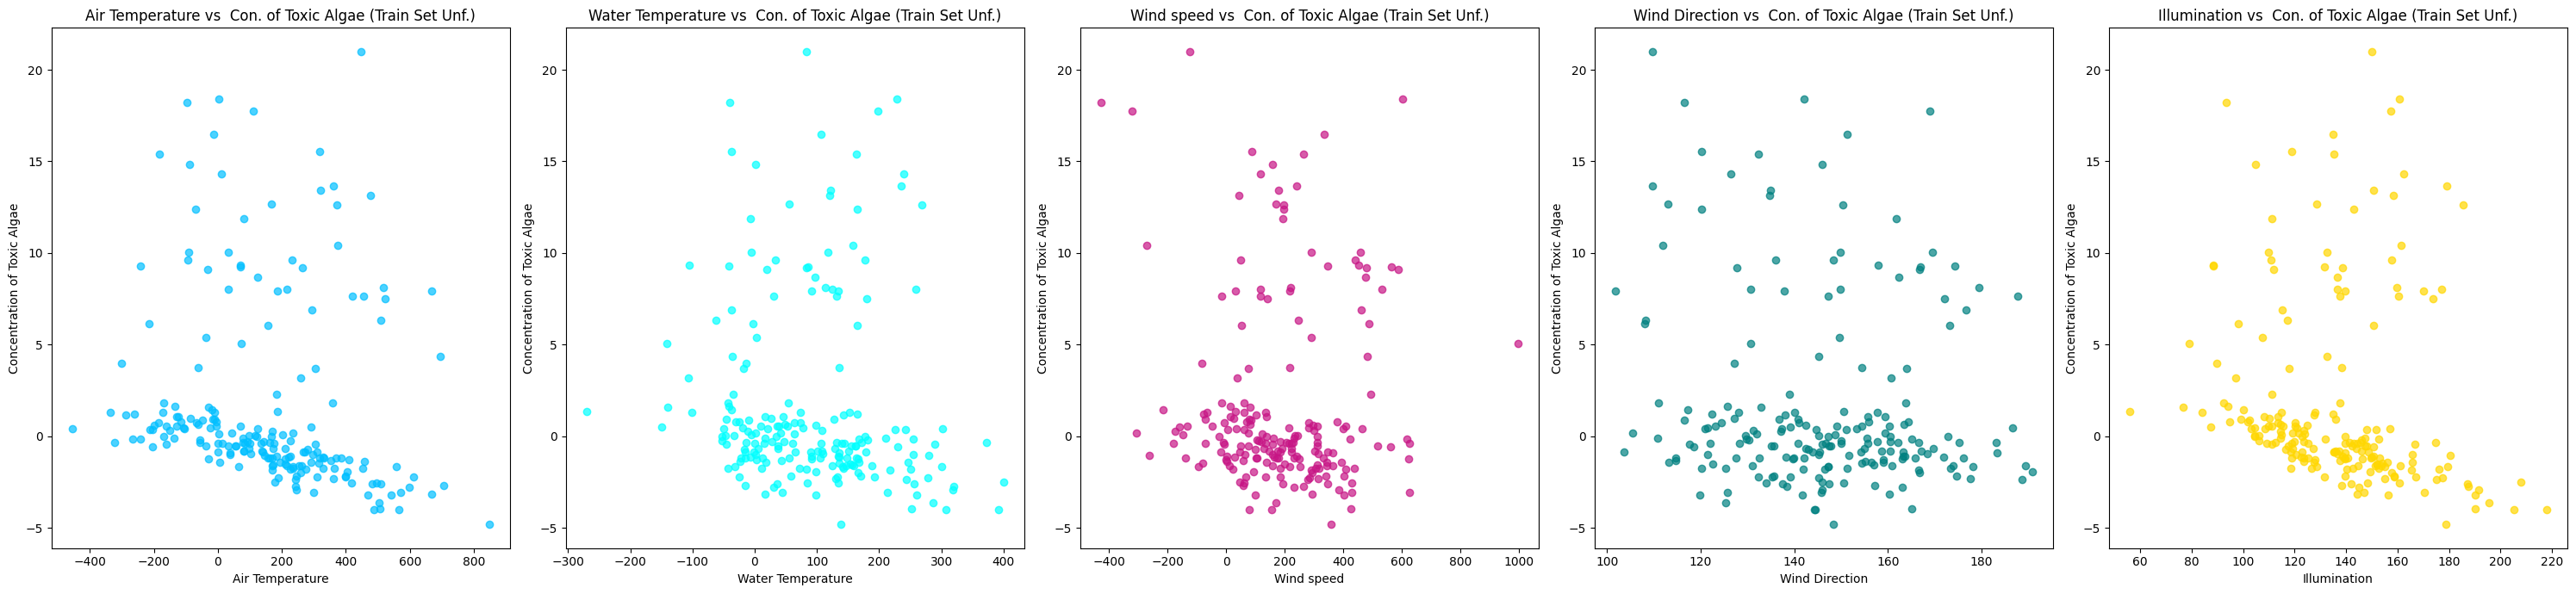

In [116]:
# Plots with training data with outliers to visualize the data
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(train_data_unfiltered[feature], train_data_unfiltered['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set Unf.)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

**Ordinary Linear Regression for Outliers**

In [138]:
linear_model = LinearRegression()

linear_model.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])
y_pred_OLS = linear_model.predict(train_data_unfiltered[train_features])
residuals_OLS = np.square(train_data_unfiltered['Y_train'] - y_pred_OLS)
threshold_OLS = np.percentile(residuals_OLS, 75)
least_residual_points_OLS = train_data_unfiltered[residuals_OLS < threshold_OLS]
X_train_OLS, X_val_OLS, Y_train_OLS, Y_val_OLS = train_test_split(least_residual_points_OLS[train_features],least_residual_points_OLS['Y_train'],test_size=0.3, random_state=42)
scaler_OLS = StandardScaler()
X_train_OLS = scaler_OLS.fit_transform(X_train_OLS)
X_val_OLS = scaler_OLS.transform(X_val_OLS)


MSE of OLS: 0.8687961017689584


/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.430e+01, tolerance: 3.246e-02
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e+01, tolerance: 3.246e-02
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

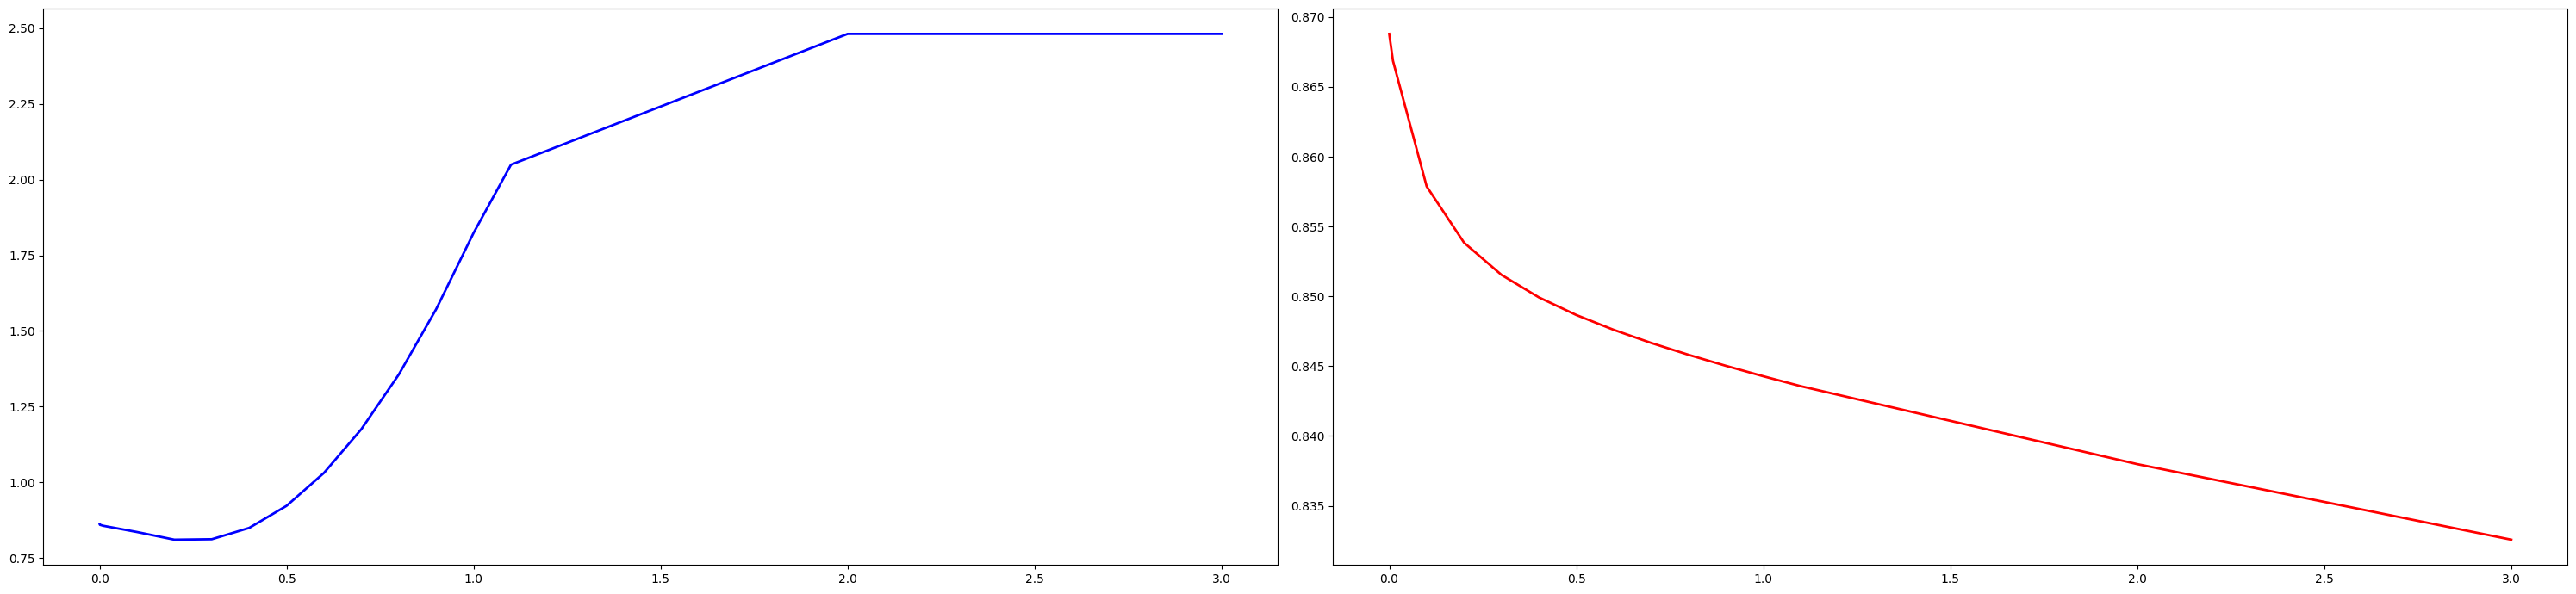

    Alpha  L1_Ratio       MSE
66    0.3      0.01  0.773272
67    0.3      0.10  0.775289
77    0.4      0.01  0.776861
68    0.3      0.20  0.779178
55    0.2      0.01  0.780119


In [139]:
lr = LinearRegression()

lr.fit(X_train_OLS, Y_train_OLS)
y_pred_OLS = lr.predict(X_val_OLS)
print(f"MSE of OLS: {mean_squared_error(Y_val_OLS, y_pred_OLS)}")

alpha = [0.000001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,2,3]

ratios = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_OLS, Y_train_OLS)
    y_pred_lasso = lasso.predict(X_val_OLS)
    lasso_mse = mean_squared_error(Y_val_OLS, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_OLS, Y_train_OLS)
    y_pred_ridge = ridge.predict(X_val_OLS)
    ridge_mse = mean_squared_error(Y_val_OLS, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j,fit_intercept=True)
        en.fit(X_train_OLS, Y_train_OLS)
        y_pred_en = en.predict(X_val_OLS)
        en_mse = mean_squared_error(Y_val_OLS, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

RANSAC Outlier detection

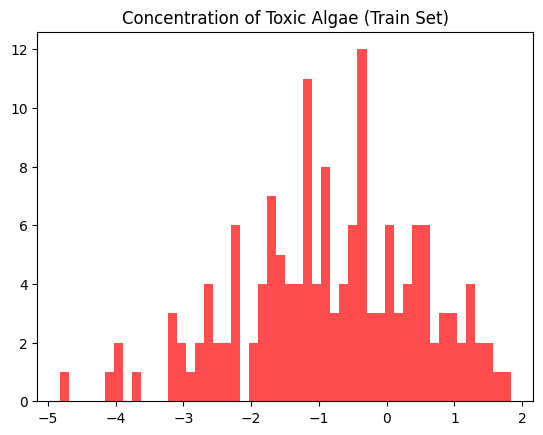

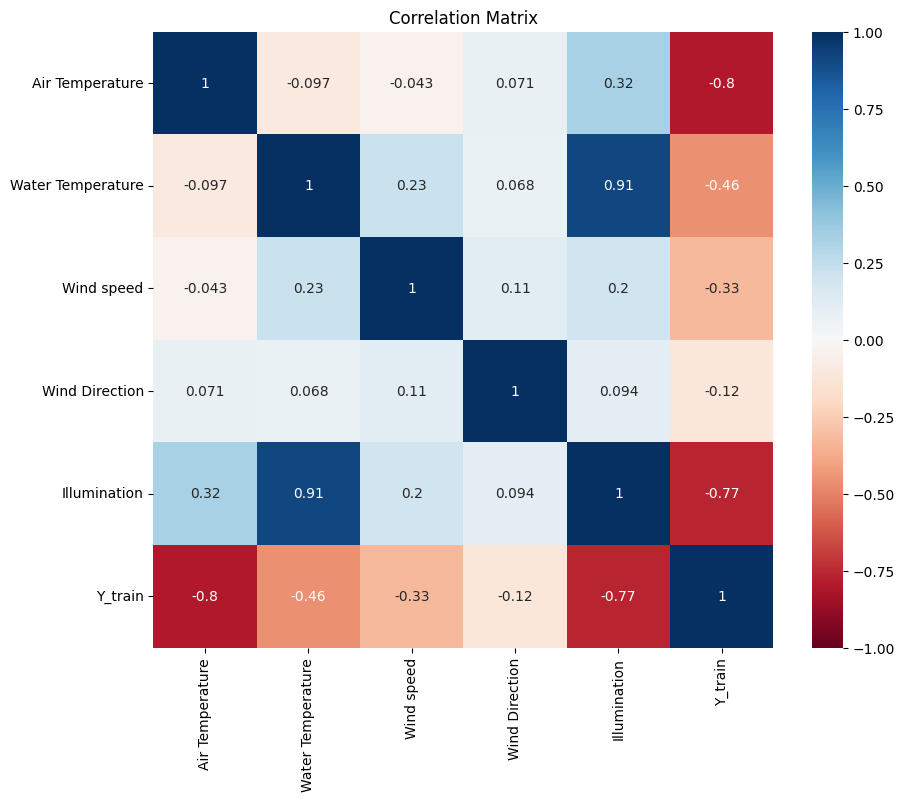

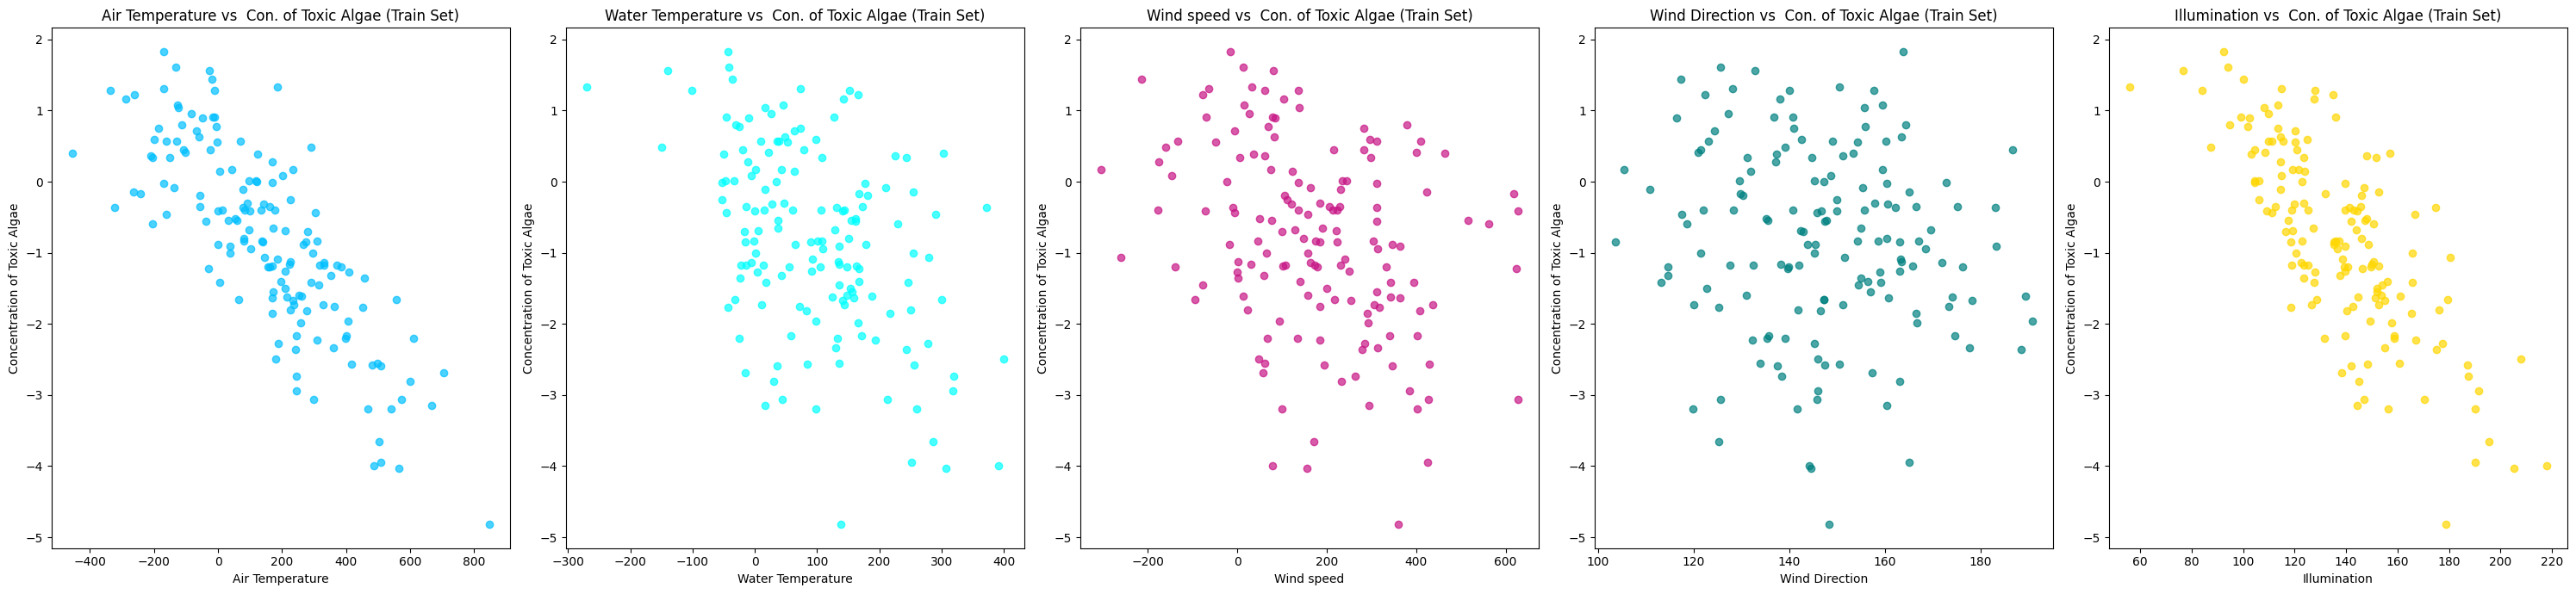

In [145]:
ransac = RANSACRegressor(
    estimator=LinearRegression(), 
    stop_n_inliers= 150, 
    random_state=42
)

ransac.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])

inlier_mask = ransac.inlier_mask_

train_data_RANSAC = train_data_unfiltered[inlier_mask]
train_data_RANSAC = train_data_RANSAC.reset_index(drop=True)

y_pred_inliers = ransac.predict(train_data_RANSAC[train_features])
residuals_RANSAC_sqr = (train_data_RANSAC['Y_train'] - y_pred_inliers)**2

plt.hist(train_data_RANSAC['Y_train'], bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.show()

correlation_matrix = train_data_RANSAC.corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(train_data_RANSAC[feature], train_data_RANSAC['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

In [120]:
scaler_RANSAC = StandardScaler()
X_train_RANSAC, X_val_RANSAC, Y_train_RANSAC, Y_val_RANSAC = train_test_split(train_data_RANSAC[train_features],train_data_RANSAC['Y_train'],test_size=0.3, random_state=42)
X_train_RANSAC = scaler_RANSAC.fit_transform(X_train_RANSAC)
X_val_RANSAC = scaler_RANSAC.transform(X_val_RANSAC)

MSE of OLS: 0.01551912310431854
0.9902933509875492
0.9902933562982009
0.9902938815117315
0.9902986075464902
0.9903414992064123
0.9905592602045911
0.9906630579194718
0.9907330922547618
0.9907908835906495
0.9908426136080348
0.9908906303862186
0.9909359975909852
0.9909792602225563
0.9910207245446928
0.9910605756872573
0.9910989324900779
0.991385133998354
0.9915902988279434


/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e-01, tolerance: 1.909e-02
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.330e-01, tolerance: 1.909e-02
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

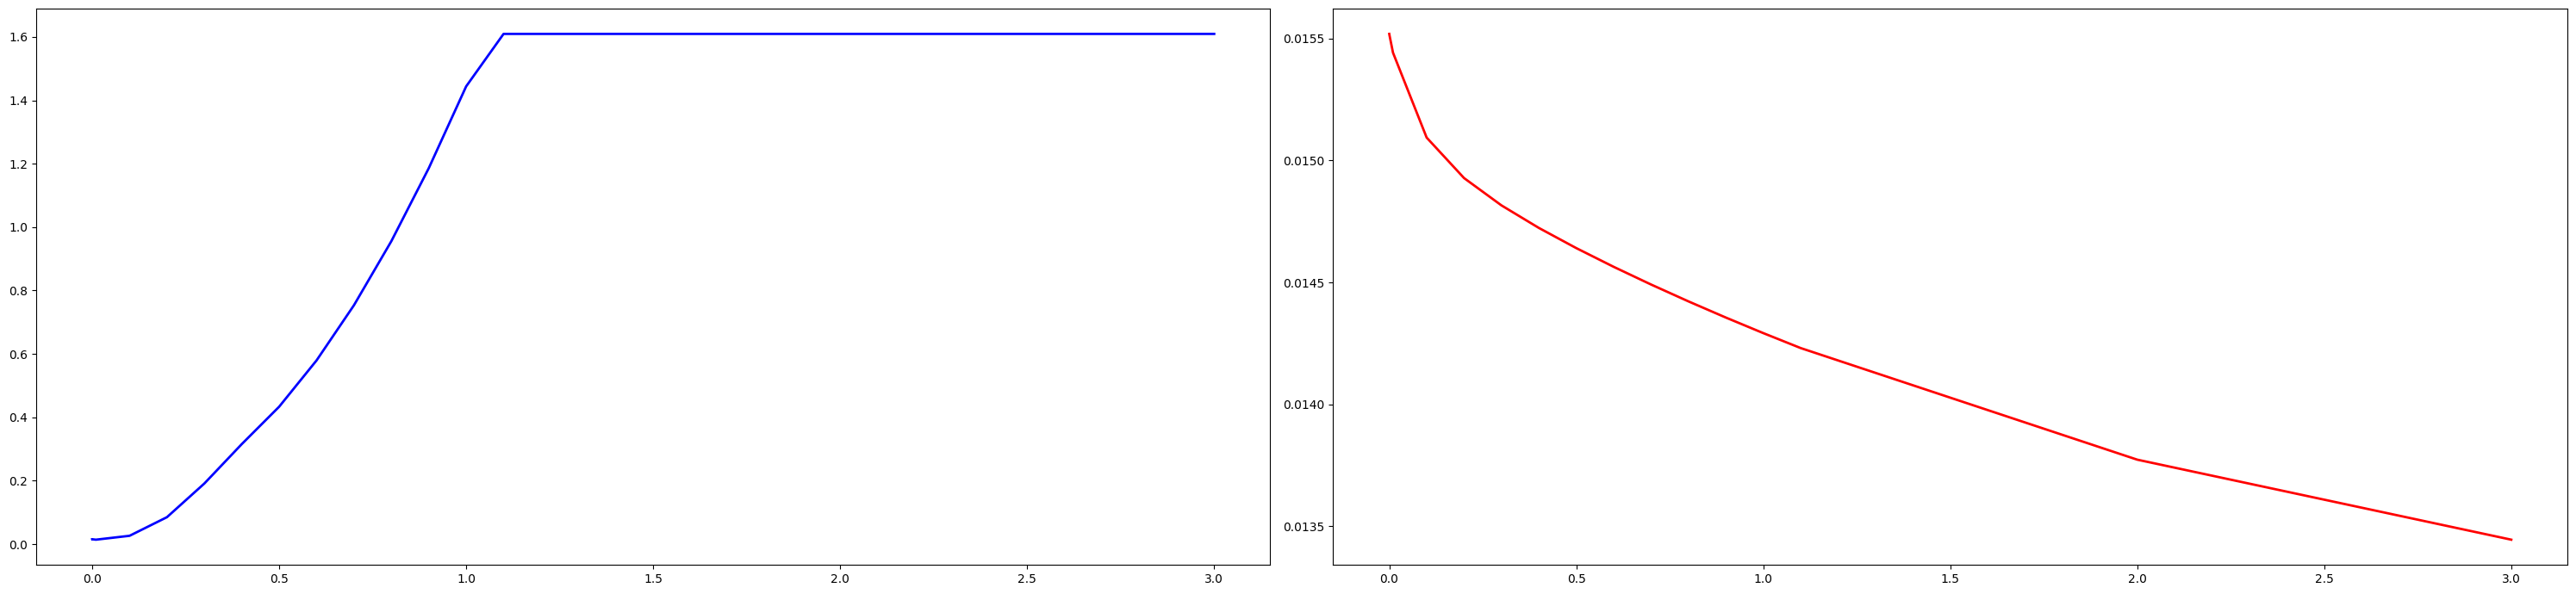

    Alpha  L1_Ratio       MSE
43   0.01       1.0  0.013948
42   0.01       0.9  0.013963
41   0.01       0.8  0.013980
40   0.01       0.7  0.013996
39   0.01       0.6  0.014013


In [140]:
lr = LinearRegression()

lr.fit(X_train_RANSAC, Y_train_RANSAC)
y_pred_OLS = lr.predict(X_val_RANSAC)
print(f"MSE of OLS: {mean_squared_error(Y_val_RANSAC, y_pred_OLS)}")
print(lr.score(X_val_RANSAC, Y_val_RANSAC))
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_RANSAC, Y_train_RANSAC)
    y_pred_lasso = lasso.predict(X_val_RANSAC)
    lasso_mse = mean_squared_error(Y_val_RANSAC, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_RANSAC, Y_train_RANSAC)
    y_pred_ridge = ridge.predict(X_val_RANSAC)
    ridge_mse = mean_squared_error(Y_val_RANSAC, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])
    print(ridge.score(X_val_RANSAC, Y_val_RANSAC))

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j,fit_intercept=True)
        en.fit(X_train_RANSAC, Y_train_RANSAC)
        y_pred_en = en.predict(X_val_RANSAC)
        en_mse = mean_squared_error(Y_val_RANSAC, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

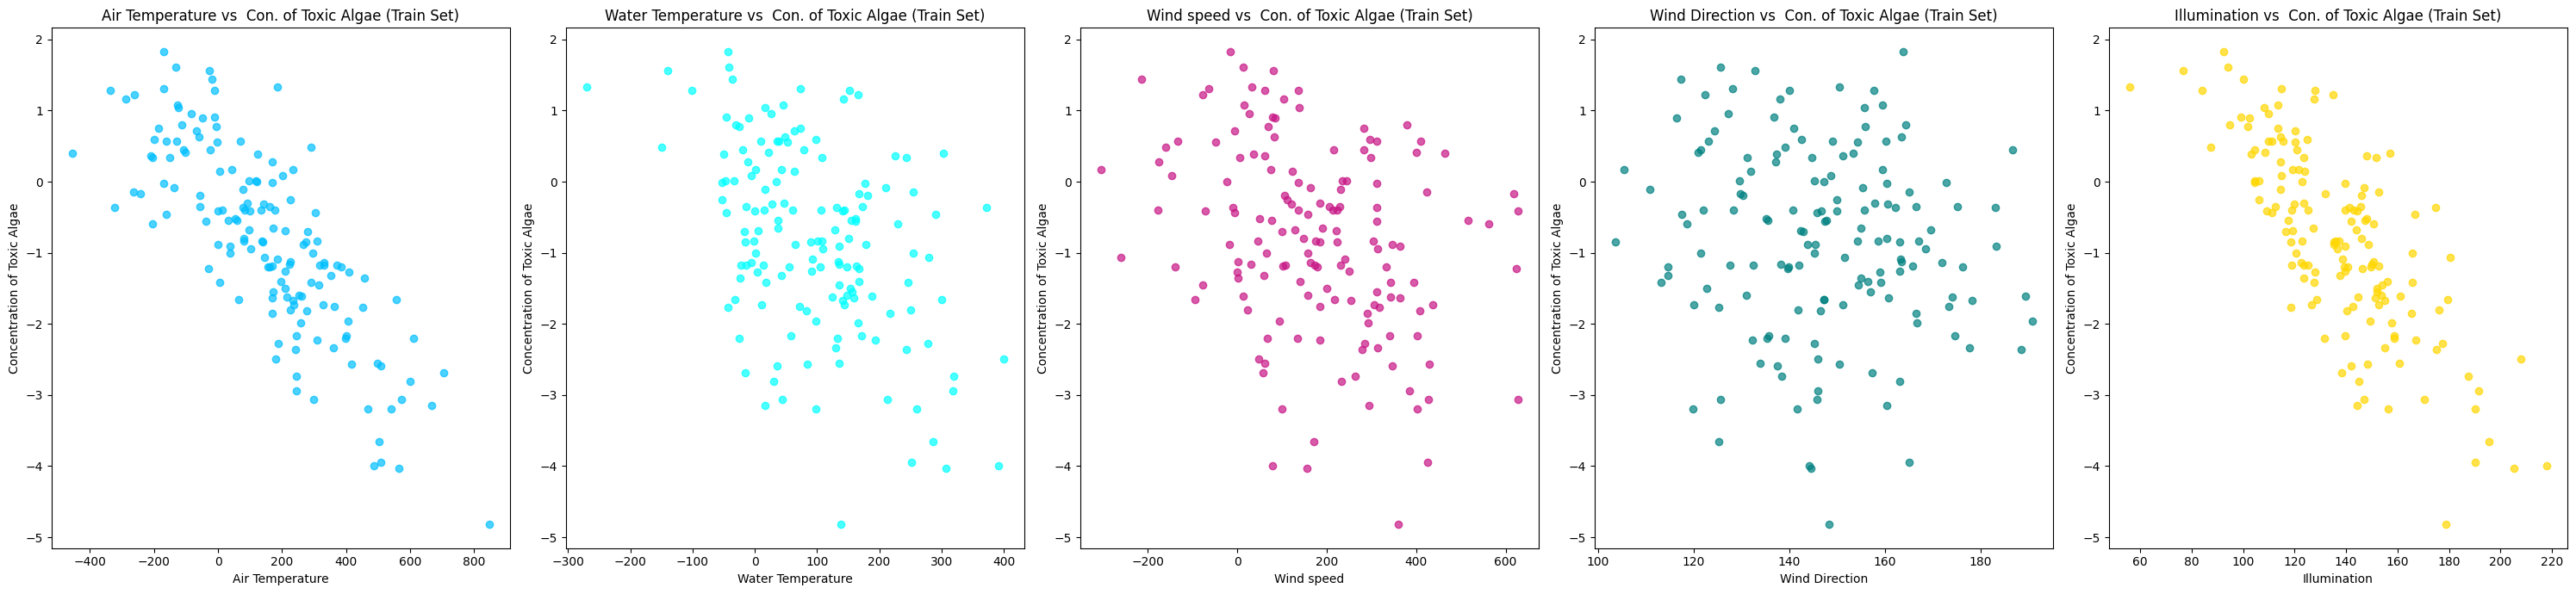

In [122]:
huber_reg = HuberRegressor()
huber_reg.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])
y_pred_HR = huber_reg.predict(train_data_unfiltered[train_features])
residuals_HR = np.square(train_data_unfiltered['Y_train'] - y_pred_HR)
threshold_HR = np.percentile(residuals_HR, 75)
least_residual_points = train_data_unfiltered[residuals_HR < threshold_HR]
X_train_HR, X_val_HR, Y_train_HR, Y_val_HR = train_test_split(least_residual_points[train_features],least_residual_points['Y_train'],test_size=0.3, random_state=42)
scaler_HR = StandardScaler()
X_train_HR = scaler_HR.fit_transform(X_train_HR)
X_val_HR = scaler_HR.transform(X_val_HR)
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(least_residual_points[feature], least_residual_points['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

MSE of OLS: 0.000249094913070469
0.9998690650407152
0.9998690641920235
0.9998772412697895
0.999868980073008
0.9998748293048351
0.9998682065772454
0.9998231584374787
0.9998597535903088
0.9991834343086295
0.999766366425482
0.9874644590470151
0.9996935193309944
0.9512763308606469
0.9996452776799303
0.8907067031719194
0.9996105486374646
0.8121581964388886
0.9995834809714554
0.7254080233662501
0.9995609276541894
0.6181547346172471
0.9995410812287968
0.4904010002309883
0.9995228389143929
0.3421458501600052
0.999505493096432
0.17338965434903542
0.9994885705240659
0.022178336167232304
0.9994717436948073
-0.0017639507988482794
0.9993003897033761
-0.0017639507988482794
0.9990379765525111
-0.0017639507988482794


/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-02, tolerance: 1.730e-02
  model = cd_fast.enet_coordinate_descent(


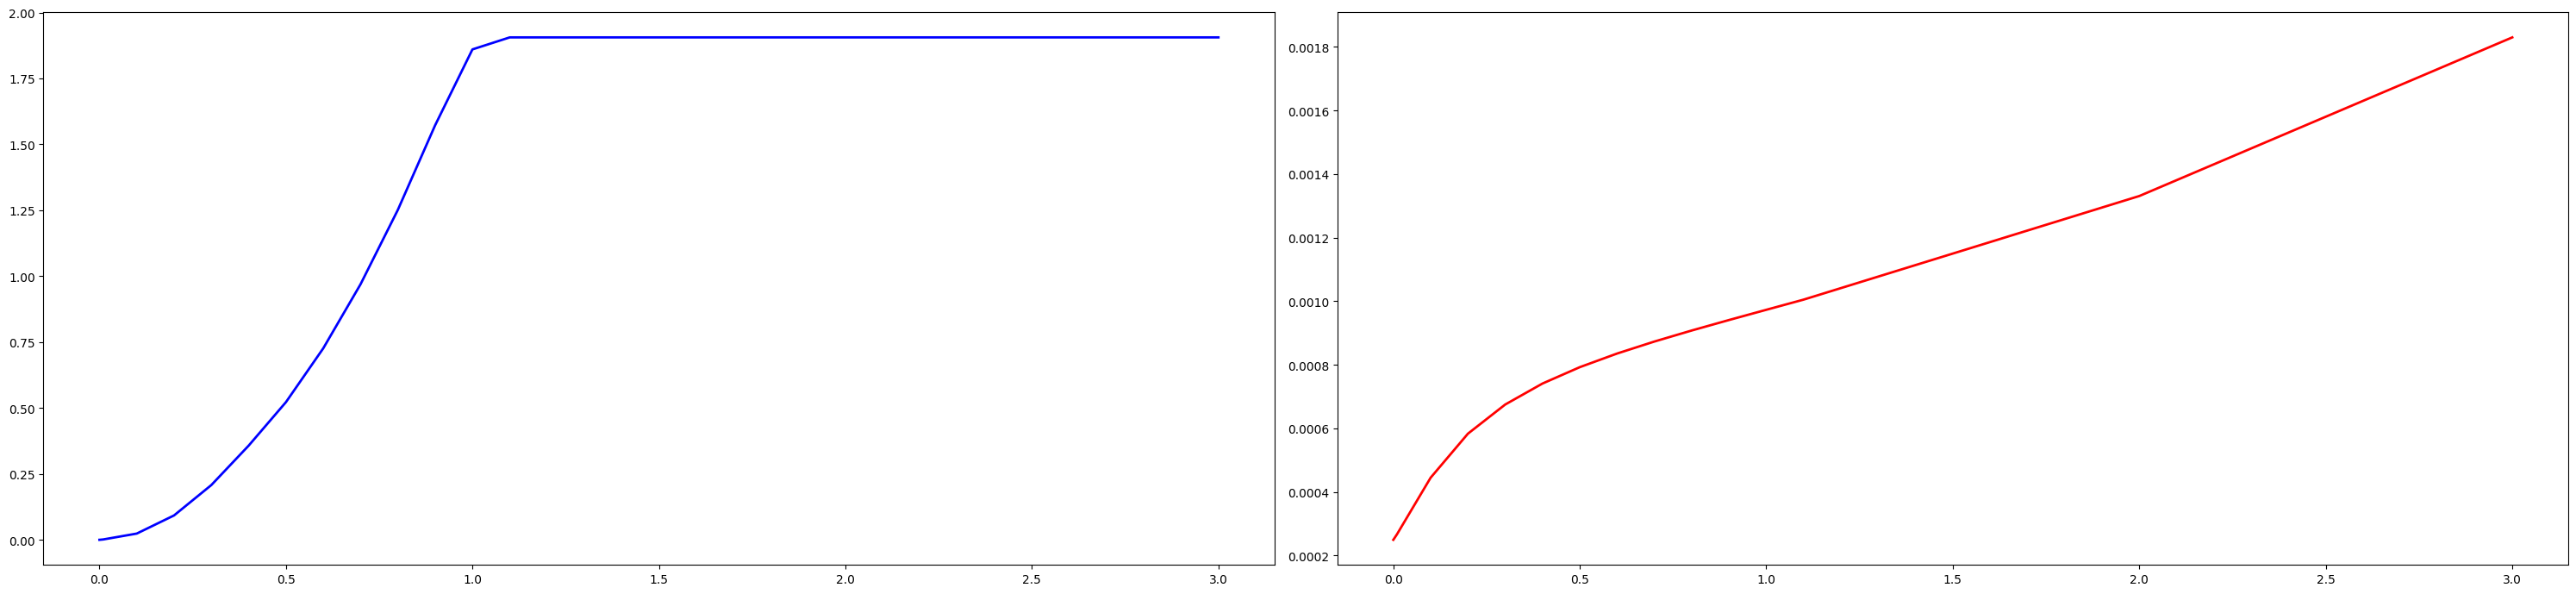

       Alpha  L1_Ratio       MSE
10  0.000001       1.0  0.000234
9   0.000001       0.9  0.000234
8   0.000001       0.8  0.000234
7   0.000001       0.7  0.000234
6   0.000001       0.6  0.000234


In [142]:
lr = LinearRegression()
lr.fit(X_train_HR, Y_train_HR)
y_pred_OLS = lr.predict(X_val_HR)
print(f"MSE of OLS: {mean_squared_error(Y_val_HR, y_pred_OLS)}")
print(lr.score(X_val_HR, Y_val_HR))
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_HR, Y_train_HR)
    y_pred_lasso = lasso.predict(X_val_HR)
    lasso_mse = mean_squared_error(Y_val_HR, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_HR, Y_train_HR)
    y_pred_ridge = ridge.predict(X_val_HR)
    ridge_mse = mean_squared_error(Y_val_HR, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j,fit_intercept=True)
        en.fit(X_train_HR, Y_train_HR)
        y_pred_en = en.predict(X_val_HR)
        en_mse = mean_squared_error(Y_val_HR, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

**Theil–Sen estimator for removing outliers**

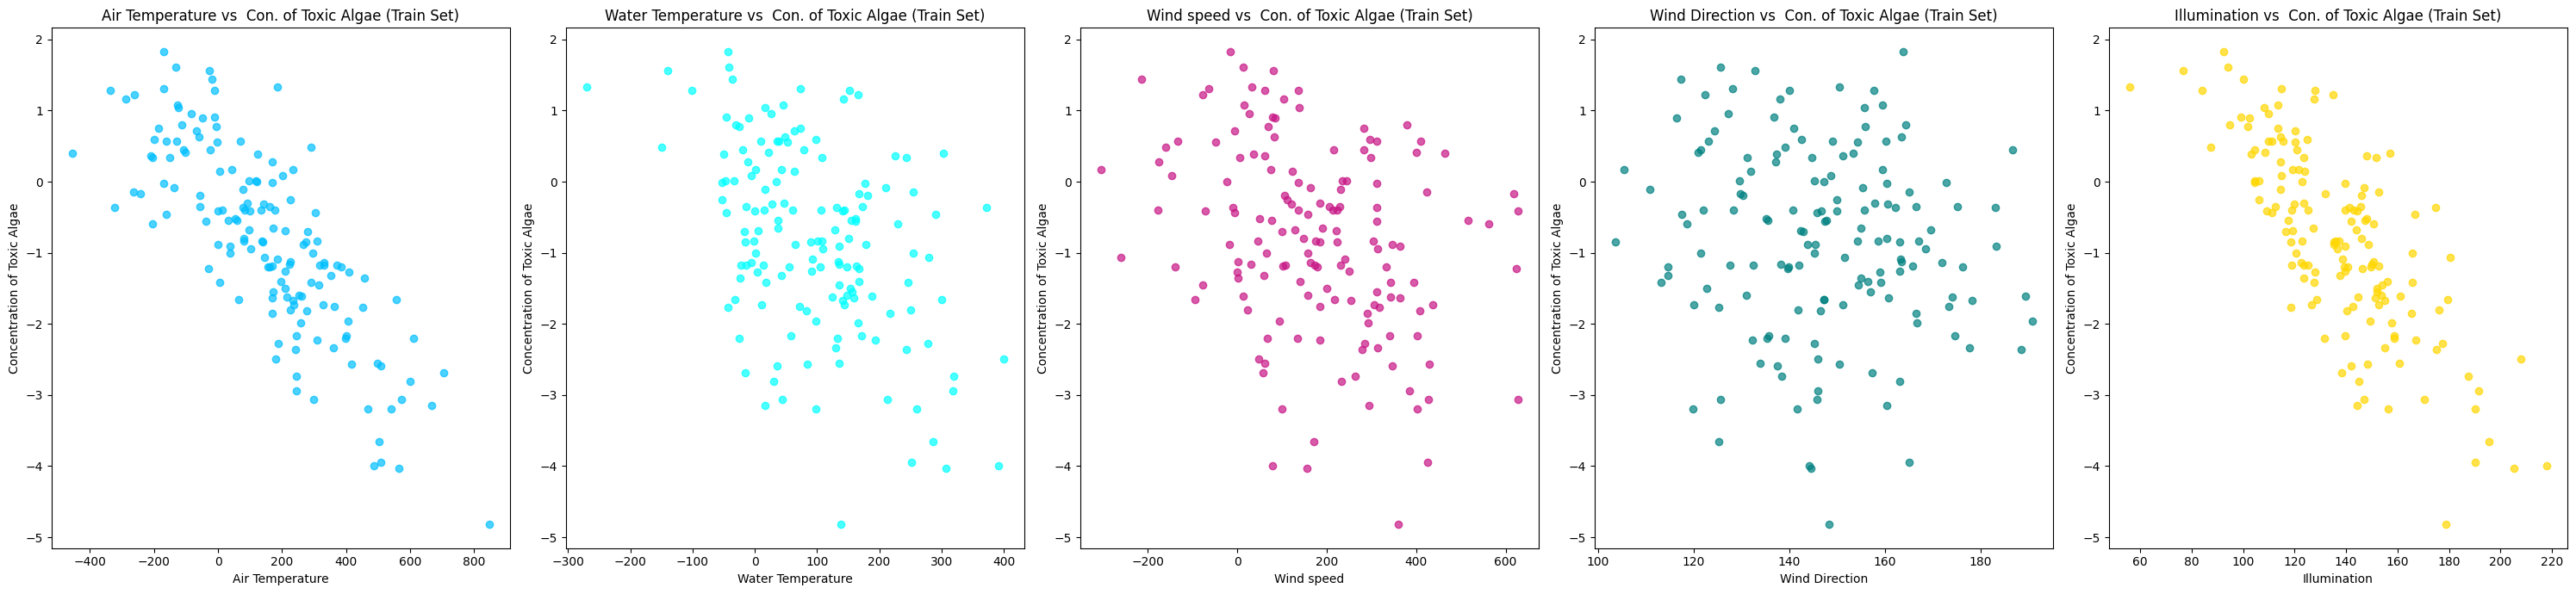

In [124]:
TheilSen = TheilSenRegressor(random_state=42)
TheilSen.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])
y_pred_TS = TheilSen.predict(train_data_unfiltered[train_features])
residuals_TS = np.square(train_data_unfiltered['Y_train'] - y_pred_HR)
threshold_TS = np.percentile(residuals_TS, 75)
least_residual_TS = train_data_unfiltered[residuals_TS < threshold_TS]
X_train_TS, X_val_TS, Y_train_TS, Y_val_TS = train_test_split(least_residual_TS[train_features],least_residual_TS['Y_train'],test_size=0.3, random_state=42)
scaler_TS = StandardScaler()
X_train_TS = scaler_TS.fit_transform(X_train_TS)
X_val_TS = scaler_HR.transform(X_val_TS)
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(least_residual_TS[feature], least_residual_TS['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

MSE of OLS: 0.000249094913070469
0.00023354018970528074
[-1.10181878e+00 -5.46906822e-01 -3.48433785e-01 -4.37137902e-04
 -7.73761441e-02]
-0.8145053542177862
0.00023812879006023937
[-1.10167628e+00 -5.46595366e-01 -3.48432433e-01 -4.36372996e-04
 -7.76986241e-02]
-0.8145053542177862
0.0003364291239260415
[-1.10039028e+00 -5.43784761e-01 -3.48420210e-01 -4.29480398e-04
 -8.06086985e-02]
-0.8145053542177862
0.0015534610543983288
[-1.08840362e+00 -5.17598903e-01 -3.48304107e-01 -3.66191410e-04
 -1.07720138e-01]
-0.8145053542177862
0.023848019665870836
[-1.01873937e+00 -3.66112094e-01 -3.47495963e-01 -5.72135178e-05
 -2.64490097e-01]
-0.8145053542177864
0.09269348839325507
[-9.84785658e-01 -2.93320189e-01 -3.46903929e-01  6.04553306e-06
 -3.39713786e-01]
-0.8145053542177864
0.20792311252298223
[-9.66075146e-01 -2.54037922e-01 -3.46419779e-01 -2.85851078e-05
 -3.80221646e-01]
-0.8145053542177864
0.35735633924368987
[-9.54060218e-01 -2.29472753e-01 -3.45983493e-01 -1.05916462e-04
 -4.054826

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-02, tolerance: 1.730e-02
  model = cd_fast.enet_coordinate_descent(


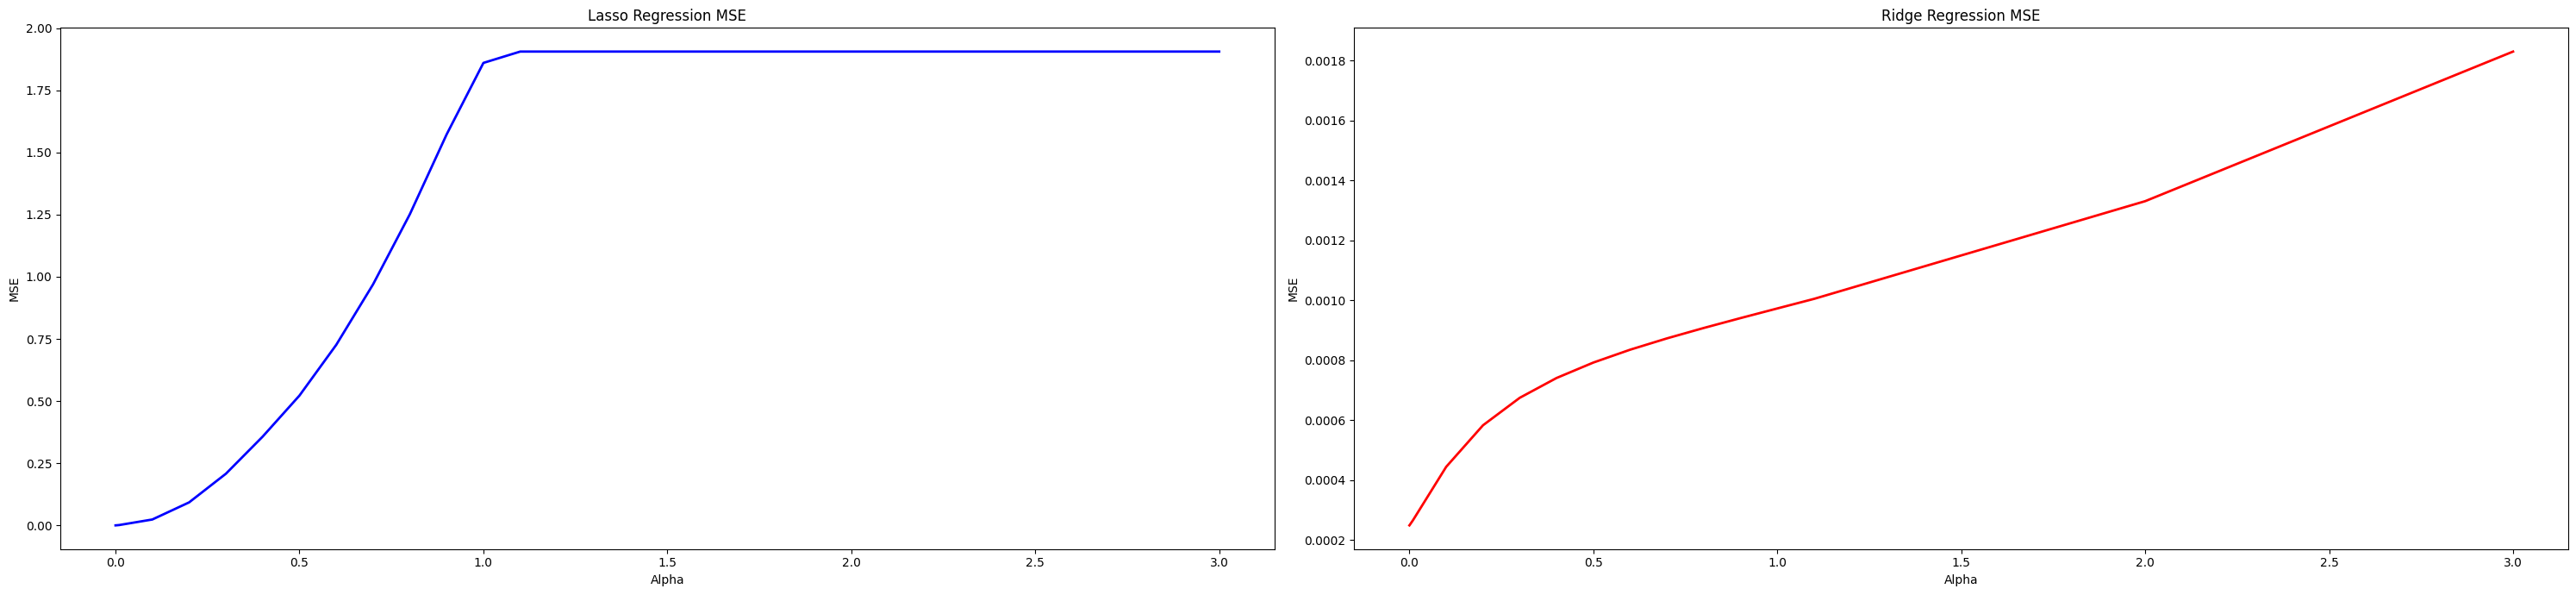

       Alpha  L1_Ratio       MSE
10  0.000001       1.0  0.000234
9   0.000001       0.9  0.000234
8   0.000001       0.8  0.000234
7   0.000001       0.7  0.000234
6   0.000001       0.6  0.000234


In [143]:
lr = LinearRegression()
lr.fit(X_train_TS, Y_train_TS)
y_pred_OLS = lr.predict(X_val_TS)
print(f"MSE of OLS: {mean_squared_error(Y_val_TS, y_pred_OLS)}")
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_TS, Y_train_TS)
    y_pred_lasso = lasso.predict(X_val_TS)
    lasso_mse = mean_squared_error(Y_val_TS, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    print(mean_squared_error(Y_val_TS, y_pred_lasso))
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_TS, Y_train_TS)
    y_pred_ridge = ridge.predict(X_val_TS)
    ridge_mse = mean_squared_error(Y_val_TS, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(X_train_TS, Y_train_TS)
        y_pred_en = en.predict(X_val_TS)
        en_mse = mean_squared_error(Y_val_TS, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[0].set_title('Lasso Regression MSE (Outliers removed with)')
axes[0].set_xlabel('Alpha')                
axes[0].set_ylabel('MSE')                  
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
axes[1].set_title('Ridge Regression MSE (Outliers removed with)') 
axes[1].set_xlabel('Alpha')               
axes[1].set_ylabel('MSE')                  
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

In [150]:
print("Huber Regressor: {:.2e}\n"
      "Ordinary Least Squares: {:.2e}\n"
      "Theil Sen Regressor: {:.2e}\n"
      "RANSAC: {:.2e}".format(
          residuals_HR[residuals_HR < threshold_HR].mean(),
          residuals_OLS[residuals_OLS < threshold_OLS].mean(),
          residuals_TS[residuals_TS < threshold_TS].mean(),
          np.mean(residuals_RANSAC_sqr)
      ))



Huber Regressor: 5.91e-04
Ordinary Least Squares: 5.94e+00
Theil Sen Regressor: 5.91e-04
RANSAC: 7.49e-03


**Cross-validation**

In [ ]:
# Initialize the RidgeCV model with the list of alpha values
ridge_cv_model = RidgeCV(alphas=alpha, store_cv_results=True)

# Fit the model to the training data
ridge_cv_model.fit(X_train, Y_train)

# Access the best alpha value chosen during cross-validation
best_alpha = ridge_cv_model.alpha_
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values = ridge_cv_model.cv_results_
cv_df = pd.DataFrame(cv_values, columns=[f'Alpha: {alpha}' for alpha in alpha])

# Display the cross-validation values
print("\nCross-Validation MSE for each alpha and fold:")
print(cv_df.head())

# Make predictions on the test set
y_pred = ridge_cv_model.predict(X_test)

# Evaluate the model performance (e.g., R^2 score)
r2_score = ridge_cv_model.score(X_val, Y_val)
print(f"\nR² score on test data: {r2_score}")

In [ ]:
# Initialize the LassoCV model with the list of alpha values
lasso_cv_model = LassoCV(cv=5, random_state=0)

# Fit the model to the training data
lasso_cv_model.fit(X_train, Y_train)

# Access the best alpha value chosen during cross-validation
best_alpha = lasso_cv_model.alpha_
print(f"Best alpha: {best_alpha}")

coefficients = lasso_cv_model.coef_
print("Coefficients:", coefficients)

intercept = lasso_cv_model.intercept_
print("Intercept:", intercept)

mse_path = lasso_cv_model.mse_path_
print("Cross-Validation MSE for each alpha and fold::\n", mse_path)

# Make predictions on the test set
y_pred = lasso_cv_model.predict(X_test)

# Evaluate the model performance (e.g., R^2 score)
r2_score = lasso_cv_model.score(X_val, Y_val)
print(f"\nR² score on test data: {r2_score}")

In [ ]:
# Creating different folds

kf = KFold(n_splits = 5, shuffle = True)


#Defining the OLS model

kf_ols = LinearRegression()
ols_5fold = []

# Defining the hyperparameter space

param_kf_ols = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Using randomized search
for i in range(100):
    ols_grid_search = GridSearchCV(kf_ols, param_kf_ols, 
        cv= kf,
        scoring=make_scorer(mean_squared_error, greater_is_better=False), 
        return_train_score = True)
    ols_grid_search.fit(X_train, Y_train)
    ols_5fold = pd.DataFrame(ols_grid_search.cv_results_)
    ols_5fold = ols_5fold[[i for i in ols_5fold.columns if 'split' not in i and 'time' not in i and 'std' not in i and 'params' not in i]].sort_values(by='rank_test_score')
    ols_5fold = pd.concat([ols_5fold, ols_5fold])

#print R^2 

# Display the concatenated DataFrame
ols_5fold